Final notebooks to include every graph/table

## Data

[Download](https://x.com/i/communitynotes/download-data) the data from x.com. The description of each dataset is [here](https://communitynotes.x.com/guide/en/under-the-hood/download-data).
For accessing the scores, the [note scoring algorithm](https://github.com/twitter/communitynotes) needs to applied on the provided datasets. 

In this notebook we applied scoring algorithm to the data before Feb 2025 and used it for Regression Discontinuty Desgin analysis (applied on 2024 data only). Otherwise, we used most recent note and note_history notebook containing data to end of June 2025.

[bring merge scripts and updaing dates here.]

# Environment

see requirements.txt or communitynotes2025-05-09.yml

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle
import calendar
from sklearn import linear_model
import statsmodels.formula.api as smf

In [2]:
# import notes
notes = pd.read_parquet('notes.parquet', engine='auto')
# limit it to the last day of June 2025
notes = notes[notes.createdAt < pd.Timestamp(2025, 7, 1)]

### Active authors per month
written at least one note in the reference month

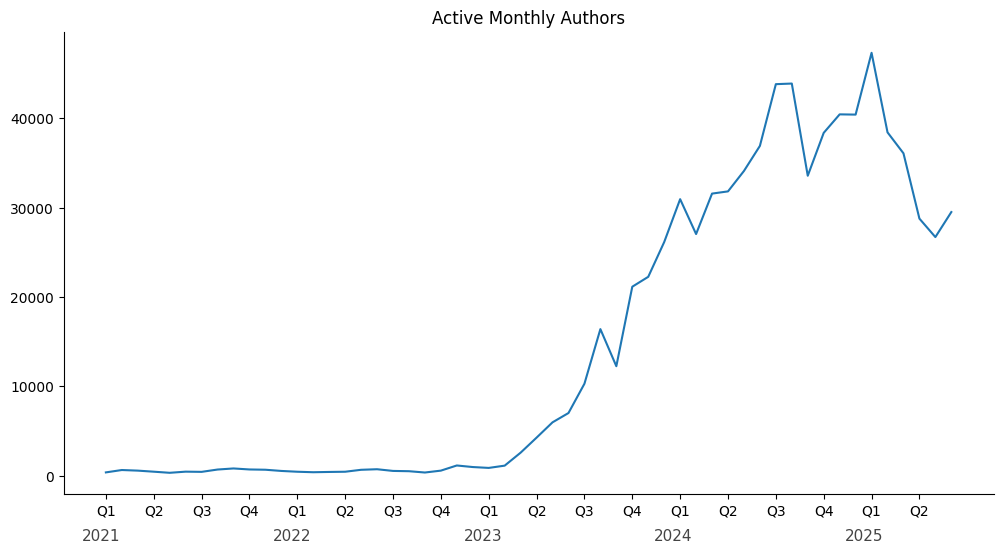

In [3]:
# active users per month
active_authors_monthly = notes.groupby(['createdAtYear', 'createdAtMonth'])\
    .agg({'noteAuthorParticipantId': 'nunique'}).reset_index()
active_authors_monthly.rename(columns={'noteAuthorParticipantId': 'count'}, inplace=True)
# plot active authors monthly
fig, ax = plt.subplots(figsize=(12,6))
# ax.plot(active_authors_monthly.index,active_authors_monthly['count'])
ax.plot(active_authors_monthly['count'])

ax.set_xticks(np.arange(0,len(active_authors_monthly), step=3))
# set quartely labels
labels = [''] * len(ax.get_xticks())
for idx, element in enumerate(labels):
    labels[idx] = 'Q' + str(idx%4 + 1)

ax.set_xticklabels(labels)
# add years
for idx, year in enumerate(range(2021,2026)):
    ax.text(idx*.205 + .02 , -.1, str(year), size=11, color='#444', transform=ax.transAxes)
ax.set_title('Active Monthly Authors')
ax.spines[['right', 'top']].set_visible(False)

### Cumulative contribution of most active authors
Looking at published (helpful) notes

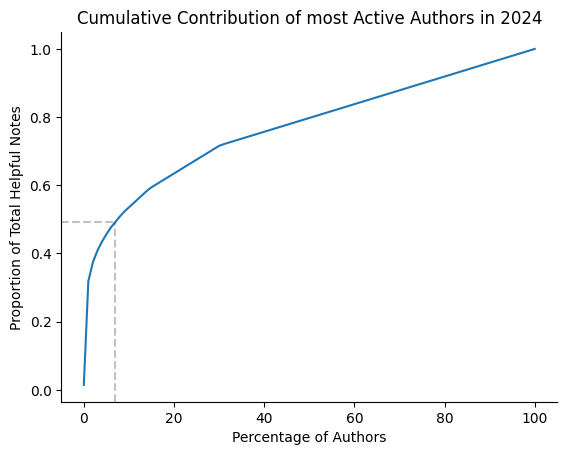

In [15]:
rated = pd.read_parquet('rated_notes_compact.parquet', engine='auto')
rated_2024 = rated[(rated.createdAt >= pd.Timestamp(2024, 1, 1)) &
                    (rated.createdAt < pd.Timestamp(2025, 1, 1))]
rated_2024_pub = rated_2024[rated_2024['finalRatingStatus'] == 'CURRENTLY_RATED_HELPFUL']
df = rated_2024_pub.groupby('noteAuthorParticipantId')['noteId']\
    .count().sort_values(ascending=False).reset_index()
df.rename(columns={'noteId': 'note_count'}, inplace=True)

# make a plot of cumulative percentages
contributions = dict()

for author_percent in range(101):
    contributions[author_percent] = df.loc[:round(len(df)*author_percent/100)]['note_count'].sum()\
          / len(rated_2024_pub)

ax = sns.lineplot(x=contributions.keys(), y=contributions.values())
ax.set_title('Cumulative Contribution of most Active Authors in 2024')
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('Percentage of Authors')
ax.set_ylabel('Proportion of Total Helpful Notes')
# save xlims
xrange = ax.get_xlim()
yrange = ax.get_ylim()
# add 50% contribution line
c = .5
x, y = min(contributions.items(), key=lambda x: abs(c - x[1]))
# add dashed line for the x and y
ax.hlines(y=y, xmin=xrange[0], xmax=x, ls='--', color="#44444452")
ax.vlines(x=x, ymin=yrange[0], ymax=y, ls='--', color="#44444452")
ax.set_xlim(xrange)
ax.set_ylim(yrange)
plt.show()

### Heatmap for active authors
What percentage of authors remained active after their first note in the upcoming years?

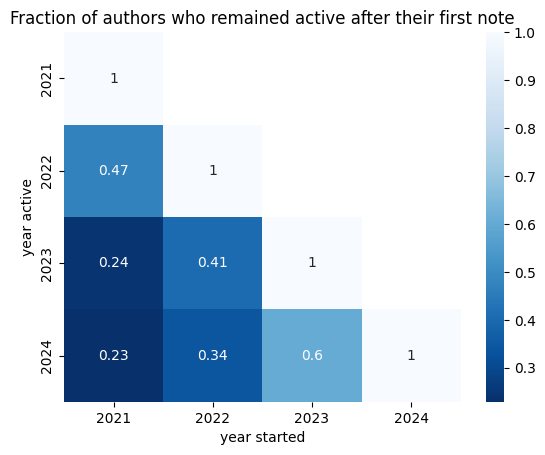

In [5]:
# make a dict of the list of unique authors each year
distinct_authors_dict = {}

for year in range(2021, 2025):
    distinct_authors_dict[year] = notes[notes['createdAtYear'] == year]['noteAuthorParticipantId'].unique()
# create a dateframe for comparing persistant authors during years
year_range = range(2021, 2025)
index = [year for year in year_range]
remain_active = pd.DataFrame(columns=index, index=index)
remain_active_matrix = np.empty(len(year_range))
for year_start in year_range:
    for year_active in year_range:
        if year_start <= year_active:
            remain_active.loc[year_active, year_start] = \
                len(np.intersect1d(distinct_authors_dict[year_start], distinct_authors_dict[year_active])) \
                    / len(distinct_authors_dict[year_start])
# plot
ax = plt.subplot()
# remove the upper triangle
mask = np.triu(np.ones_like(remain_active))
# set the diagonal to 0; so it wouldn't be masked
np.fill_diagonal(mask, 0)
sns.heatmap(remain_active.astype(float), annot = True, mask=mask, cmap='Blues_r', ax=ax)

ax.set_xlabel('year started')
ax.set_ylabel('year active')
ax.set_title('Fraction of authors who remained active after their first note')
plt.show()

### born to dead ratio

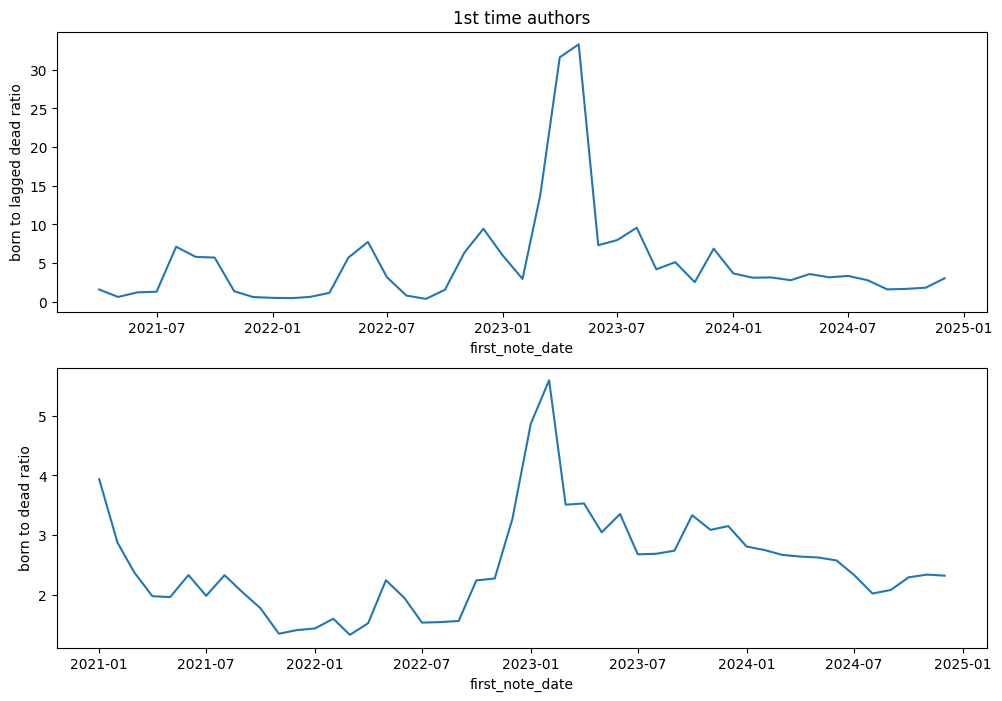

In [ ]:
#TODO decide on which graph to keep

# check if authors were inactive for 4 months after their first note
# part of code was suggested by Gemini

#number of months for inactivity
n = 4
# import notes
notes = pd.read_parquet('notes.parquet', engine='auto')
notes['createdAt'] = pd.to_datetime(notes['createdAt'])

#TODO remove authors who joined before 2024

# Find the first note date for each author
first_note = notes.groupby('noteAuthorParticipantId')['createdAt'].min().reset_index()
first_note.rename(columns={'createdAt': 'first_note_date'}, inplace=True)

# Merge the first note dates back into the original DataFrame
df = pd.merge(notes, first_note, on='noteAuthorParticipantId')

# Calculate the date 4 months after the first note
df['four_months_after_first'] = df['first_note_date'] + pd.DateOffset(months=n)

# Filter for notes within 4 months
df['note_within_4_months'] = (df['createdAt'] > df['first_note_date']) & \
    (df['createdAt'] <= df['four_months_after_first'])

# Aggregate to determine if any note was made in the 4 months
df = df.groupby('noteAuthorParticipantId')['note_within_4_months'].any().reset_index()


# merge author list with first note df
first_note = pd.merge(first_note, df, on='noteAuthorParticipantId')
# remove authors who joined after end of 2024
first_note = first_note[first_note['first_note_date'] < pd.Timestamp(2025, 1, 1)]
# now count monthly
df_monthly = first_note.set_index('first_note_date').resample('MS').count()
df_monthly['written_again'] = first_note.groupby(pd.Grouper(key='first_note_date', freq='MS'))\
    ['note_within_4_months'].sum()
df_monthly['not_written_again'] = df_monthly['note_within_4_months'] - df_monthly['written_again']
df_monthly.reset_index(inplace=True)
df_monthly.drop('noteAuthorParticipantId', axis=1, inplace=True)
df_monthly.rename(columns={'note_within_4_months': 'count_author'}, inplace=True)

# Let's check born/dead ratio
# dead: someone who hasn't written in the past n months
# born: for 1st time: write their 1st note; for 10+: write their 10th note
# in the 10+ plot, some authors can be dead multiple times, but born once
fig, ax = plt.subplots(2,1, figsize=(12,8))
n = 3
df_monthly['dead'] = df_monthly['not_written_again'].shift(n, fill_value=0)
born_to_dead = df_monthly['count_author'] / df_monthly['dead']

sns.lineplot(x=df_monthly['first_note_date'], y=born_to_dead, ax=ax[0])

ax[0].set_title('1st time authors')
ax[0].set_ylabel('born to lagged dead ratio')
sns.lineplot(x=df_monthly['first_note_date'], 
             y=df_monthly['count_author']/df_monthly['not_written_again'],
             ax=ax[1])

ax[1].set_ylabel('born to dead ratio')

plt.show()